In [1]:
import os
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset, load_from_disk
from transformers import GPT2LMHeadModel, GPT2Config, GPT2TokenizerFast, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback, pipeline
from transformers.integrations import TensorBoardCallback
from tokenizers import ByteLevelBPETokenizer
from tokenizers import Tokenizer, Regex, models, trainers, normalizers, pre_tokenizers, decoders, processors
from tokenizers.normalizers import Sequence, NFKC, Replace, Prepend
from tokenizers.pre_tokenizers import ByteLevel, Split, Whitespace
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.processors import TemplateProcessing
from itertools import chain
import glob

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
'''
!pip install --user transformers==4.44.2 --no-deps
!pip install --user tokenizers==0.19.1 --no-deps
!pip install --user huggingface-hub==0.23.4 --no-deps
'''

In [3]:
import huggingface_hub
import tokenizers
import transformers
import torch

print("huggingface-hub version:", huggingface_hub.__version__)
print("tokenizers version:", tokenizers.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)

huggingface-hub version: 0.23.4
tokenizers version: 0.19.1
transformers version: 4.44.2
transformers version: 2.1.2+cu121


In [ ]:
# Set your source folder and output file
#output_file = "gpt3-small/corpus_data/10M_corpus.txt"
output_file = "gpt3-small/corpus_data/100M_corpus.txt"

# Match both .txt and .train files
file_paths = glob.glob(os.path.join('gpt3-small/corpus_data/CHILDES_data/', '*.txt')) + \
             glob.glob(os.path.join('gpt3-small/corpus_data/BabyLM_train_100M/', '*.train'))

# Write them into a combined file
with open(output_file, "w", encoding = "utf-8") as outfile:
    for path in file_paths:
        with open(path, "r", encoding = "utf-8") as infile:
            text = infile.read().strip()
            outfile.write(text + "\n\n")  # double newline separates files

In [6]:
#corpus_file = "gpt3-small/corpus_data/10M_corpus.txt"
corpus_file = "gpt3-small/corpus_data/100M_corpus.txt"
tokenizer_dir = "gpt3-small/tokenizer"
os.makedirs(tokenizer_dir, exist_ok = True)

# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE())

# Add Normalization (Unicode + formatting cleanup)
tokenizer.normalizer = Sequence([
    Prepend(" "),
    NFKC(),
    Replace(Regex("\n"), "\n "),
    Replace(Regex(" *\n"), "\n"),
])

# Add Pre-tokenizer (Unicode-aware + byte-level + max length split)
'''
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    #Split(
    #    Regex(r"[^\\r\\n\\p{L}\\p{N}]?[\\p{Lu}\\p{Lt}\\p{Lm}\\p{Lo}\\p{M}]*[\\p{Ll}\\p{Lm}\\p{Lo}\\p{M}]+|[^\\r\\n\\p{L}\\p{N}]?[\\p{Lu}\\p{Lt}\\p{Lm}\\p{Lo}\\p{M}]+[\\p{Ll}\\p{Lm}\\p{Lo}\\p{M}]*| ?\\p{N}| ?[^\\s\\p{L}\\p{N}]+[\\r\\n/]*|\\s*[\\r\\n]+|\\s+(?!\\S)|\\s+"),
    #    behavior = "isolated"),
    ByteLevel(add_prefix_space = False, use_regex = False, trim_offsets = True),
    #Split(Regex(".{1,24}"), behavior = "isolated")
])
'''
tokenizer.pre_tokenizer = Whitespace()

# Add Decoder (to reverse tokenization)
tokenizer.decoder = decoders.Sequence([
    ByteLevelDecoder(add_prefix_space = False, use_regex = False),
    decoders.Strip(" ", 1, 0),
    decoders.Replace("\n ", "\n"),
])

# Add Post-processor (for start-of-text markers)
#start_token = "<s>"
#tokenizer.post_processor = TemplateProcessing(
#    single = f"{start_token} $A",
#    pair = f"{start_token} $A {start_token} $B",
#    special_tokens = [(start_token, 1)]
#)
tokenizer.post_processor = processors.ByteLevel(trim_offsets = False)

# Train tokenizer
trainer = trainers.BpeTrainer(
    vocab_size = 50257,
    min_frequency = 2,
    #special_tokens = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
)
tokenizer.train(files = [corpus_file], trainer = trainer)

# Save the tokenizer (as tokenizer.json)
tokenizer.save(os.path.join(tokenizer_dir, "tokenizer.json"))

In [7]:
# Load tokenizer with HuggingFace wrapper
tokenizer = GPT2TokenizerFast(tokenizer_file = "gpt3-small/tokenizer/tokenizer.json")
#tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
# Optional: set pad token if using Trainer API or batches
tokenizer.pad_token = tokenizer.eos_token

# Load your dataset (can also use raw text)
#dataset = load_dataset("text", data_files = {"train": "gpt3-small/corpus_data/10M_corpus.txt"})["train"]
dataset = load_dataset("text", data_files = {"train": "gpt3-small/corpus_data/100M_corpus.txt"})["train"]

'''
# Tokenize the dataset
def tokenize(example):
    return tokenizer(example["text"], truncation = True, padding = "max_length", max_length = 2048)
dataset = dataset.map(tokenize, batched = True, remove_columns = ["text"])
dataset.set_format(type = "torch", columns = ["input_ids", "attention_mask"])
'''

# Tokenize each example (no truncation, no padding)
def tokenize(example):
    return tokenizer(example["text"])

tokenized_dataset = dataset.map(tokenize, batched = True, remove_columns = ["text"], num_proc = 4)

# Save tokenized dataset for reuse (use load_from_disk latter)
tokenized_dataset.save_to_disk("gpt3-small/corpus_data/tokenized_dataset")

# Concatenate all input_ids and attention masks into single token streams
def concat(examples):
    return {
        "input_ids": [list(chain.from_iterable(examples["input_ids"]))],
        "attention_mask": [list(chain.from_iterable(examples["attention_mask"]))]
    }

concated_dataset = tokenized_dataset.map(concat, batched = True, batch_size = 1000000, num_proc = 4)

# Chunk into fixed-size blocks (2048 tokens, GPT-3 style)
def chunk(examples):
    chunk_size = 2048 # 1024 if GPT-2 
    input_ids = examples["input_ids"][0]
    attention_mask = examples["attention_mask"][0]

    input_chunks = []
    attention_chunks = []

    # slice with step_size = chunk_size
    for i in range(0, len(input_ids), chunk_size):
        chunk = input_ids[i : i + chunk_size]
        if len(chunk) == chunk_size: # drop the last chunk if not equal
            input_chunks.append(chunk)
            attention_chunks.append(attention_mask[i : i + chunk_size])

    return {
        "input_ids": input_chunks,
        "attention_mask": attention_chunks
    }

chunked_dataset = concated_dataset.map(chunk, batched = True, batch_size = 2, num_proc = 2)

# Save the final preprocessed dataset for model training
chunked_dataset.save_to_disk("gpt3-small/corpus_data/chunked_dataset")
chunked_dataset = load_from_disk("gpt3-small/corpus_data/chunked_dataset")

Using custom data configuration default-ceda9be804afc706
Reusing dataset text (/home/stellacy/.cache/huggingface/datasets/text/default-ceda9be804afc706/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)
Parameter 'function'=<function tokenize at 0x1482904f1310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function tokenize at 0x1482904f1310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or 

 #0:   0%|          | 0/1799 [00:00<?, ?ba/s]

 #1:   0%|          | 0/1799 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x1482904f1310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #2:   0%|          | 0/1799 [00:00<?, ?ba/s]

Parameter 'function'=<function tokenize at 0x1482904f1310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #3:   0%|          | 0/1799 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x14832bf50790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #0:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x14832bf50790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #1:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x14832bf50790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #2:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function concat at 0x14832bf50790> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


 #3:   0%|          | 0/2 [00:00<?, ?ba/s]

Parameter 'function'=<function chunk at 0x14829044c940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Parameter 'function'=<function chunk at 0x14829044cd30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subse

 #0:   0%|          | 0/2 [00:00<?, ?ba/s]

 #1:   0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
# Load model config and model
#config = GPT2Config.from_json_file("gpt3_small_config.json")
config = GPT2Config(
    vocab_size = 50257,
    n_positions = 2048, # GPT-3 context length
    n_ctx = 2048,
    n_embd = 768,
    n_layer = 12,
    n_head = 12,
    
    # GPT-3 uses no dropout during pretraining
    resid_pdrop = 0.0, # 0.1 for GPT-2
    embd_pdrop = 0.0, # 0.1 for GPT-2
    attn_pdrop = 0.0, # 0.1 for GPT-2
    
    activation_function = "gelu_new", # same as GPT-2
    layer_norm_epsilon = 1e-5,
    initializer_range = 0.02,
    bos_token_id = 50256,
    eos_token_id = 50256,
    use_cache = True,
    scale_attn_weights = True,
    scale_attn_by_inverse_layer_idx = False,
    reorder_and_upcast_attn = False,
)

model = GPT2LMHeadModel(config)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, pad_to_multiple_of = None, mlm = False)

# Training arguments
training_args = TrainingArguments(
    output_dir = "./gpt3-small",
    #evaluation_strategy = "no",
    eval_strategy = "no",
    #eval_strategy = "steps",
    #eval_steps = 100,
    logging_strategy = "steps",
    logging_steps = 100,
    save_strategy = "steps",
    save_steps = 1000,
    save_total_limit = 2,
    num_train_epochs = 3,
    per_device_train_batch_size = 1,
    #per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 16,
    learning_rate = 6e-4, #3e-4 or 1e-4
    warmup_ratio = 0.02,
    weight_decay = 0.1, #0.01
    lr_scheduler_type = "cosine",
    adam_beta1 = 0.9,
    adam_beta2 = 0.95, #0.999 for GPT-2
    fp16 = True,
    logging_dir = "./gpt3-small/logs", #GPT-3 uses cross-entropy loss
    report_to = "tensorboard", 
    #load_best_model_at_end = True,
)

# Initialize Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer,
    train_dataset = chunked_dataset,
    data_collator = data_collator,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)],
    #callbacks = [TensorBoardCallback()],
)

#%load_ext tensorboard
#%tensorboard --logdir ./gpt3-small/logs

# Train the model
trainer.train()


/tmp/ipykernel_3361734/181438917.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
100,3.280800
200,2.706900
300,2.604700
400,2.545600
500,2.508100
600,2.475800
700,2.432200
800,2.373700
900,2.328800
1000,2.280300


TrainOutput(global_step=2127, training_loss=2.3247331871244343, metrics={'train_runtime': 7380.4195, 'train_samples_per_second': 9.229, 'train_steps_per_second': 0.288, 'total_flos': 7.1104878084096e+16, 'train_loss': 2.3247331871244343, 'epoch': 2.996476391825229})

In [5]:
# Load model config and model
#config = GPT2Config.from_json_file("gpt3_small_config.json")
config = GPT2Config(
    vocab_size = 50257,
    n_positions = 2048, # GPT-3 context length
    n_ctx = 2048,
    n_embd = 768,
    n_layer = 12,
    n_head = 12,
    
    # GPT-3 uses no dropout during pretraining
    resid_pdrop = 0.0, # 0.1 for GPT-2
    embd_pdrop = 0.0, # 0.1 for GPT-2
    attn_pdrop = 0.0, # 0.1 for GPT-2
    
    activation_function = "gelu_new", # same as GPT-2
    layer_norm_epsilon = 1e-5,
    initializer_range = 0.02,
    bos_token_id = 50256,
    eos_token_id = 50256,
    use_cache = True,
    scale_attn_weights = True,
    scale_attn_by_inverse_layer_idx = False,
    reorder_and_upcast_attn = False,
)

model = GPT2LMHeadModel(config)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, pad_to_multiple_of = None, mlm = False)

# Training arguments
training_args = TrainingArguments(
    output_dir = "./gpt3-small",
    #evaluation_strategy = "no",
    eval_strategy = "no",
    #eval_strategy = "steps",
    #eval_steps = 100,
    logging_strategy = "steps",
    logging_steps = 100,
    save_strategy = "steps",
    save_steps = 1000,
    save_total_limit = 2,
    num_train_epochs = 3,
    per_device_train_batch_size = 1,
    #per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 16,
    learning_rate = 6e-4, #3e-4 or 1e-4
    warmup_ratio = 0.02,
    weight_decay = 0.1, #0.01
    lr_scheduler_type = "cosine",
    adam_beta1 = 0.9,
    adam_beta2 = 0.95, #0.999 for GPT-2
    fp16 = True,
    logging_dir = "./gpt3-small/logs", #GPT-3 uses cross-entropy loss
    report_to = "tensorboard", 
    #load_best_model_at_end = True,
)

# Initialize Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer,
    train_dataset = chunked_dataset,
    data_collator = data_collator,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)],
    #callbacks = [TensorBoardCallback()],
)

#%load_ext tensorboard
#%tensorboard --logdir ./gpt3-small/logs

# Train the model
trainer.train()

/tmp/ipykernel_3361734/2684463259.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,2.890000
200,2.446300
300,2.351700


TrainOutput(global_step=369, training_loss=2.513099360272167, metrics={'train_runtime': 1286.4361, 'train_samples_per_second': 9.242, 'train_steps_per_second': 0.287, 'total_flos': 1.2387332653056e+16, 'train_loss': 2.513099360272167, 'epoch': 2.992936427850656})

In [5]:
from torch.utils.tensorboard import SummaryWriter

# Create a TensorBoard writer
writer = SummaryWriter(log_dir="./gpt3-small/logs_reconstructed")  # different folder to avoid conflicts

# Recorded steps and losses
steps_losses = [
    (100, 4.602300),
    (200, 4.119000),
    (300, 3.918800),
    (400, 3.800300),
    (500, 3.708900),
    (600, 3.628300),
    (700, 3.578700),
    (800, 3.544000),
    (900, 3.496700),
    (1000, 3.469400),
    (1100, 3.439000),
    (1200, 3.408300),
    (1300, 3.390500),
    (1400, 3.366000),
    (1500, 3.372400),
    (1600, 3.361200)
]

# Log each step and loss
for step, loss in steps_losses:
    writer.add_scalar("train/loss", loss, step)

# Close the writer to flush files
writer.close()

In [9]:
#model = GPT2LMHeadModel.from_pretrained('gpt3-small/checkpoint-pretrainedtokenizer_100M')
model = GPT2LMHeadModel.from_pretrained('gpt3-small/checkpoint-trainedtokenizer_100M')
#tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer = GPT2TokenizerFast(tokenizer_file = "gpt3-small/checkpoint-trainedtokenizer_100M/tokenizer.json")

In [7]:
generator = pipeline("text-generation", model = model, tokenizer = tokenizer)
print(generator("Once upon a time", max_length = 50, do_sample = True, top_k = 50))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'generated_text': "Once upon a time that's that is thiput that the put thone you put_of here two to me more is this look it well"}]


Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


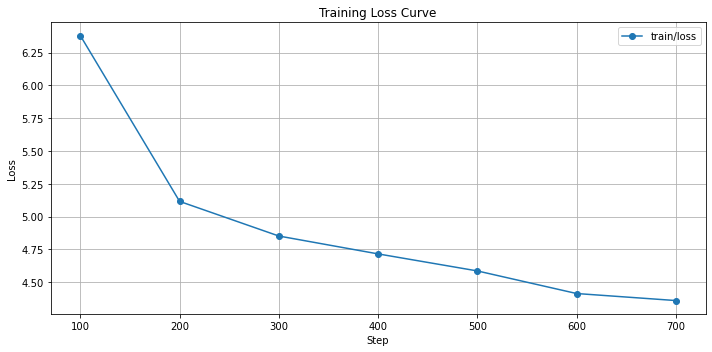

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.pretrainedtokenizer.10M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


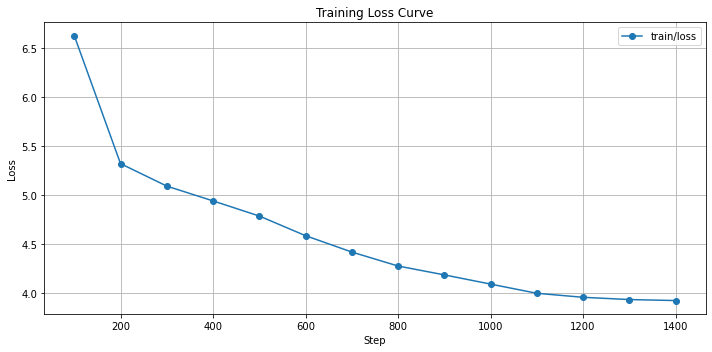

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.pretrainedtokenizer.100M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


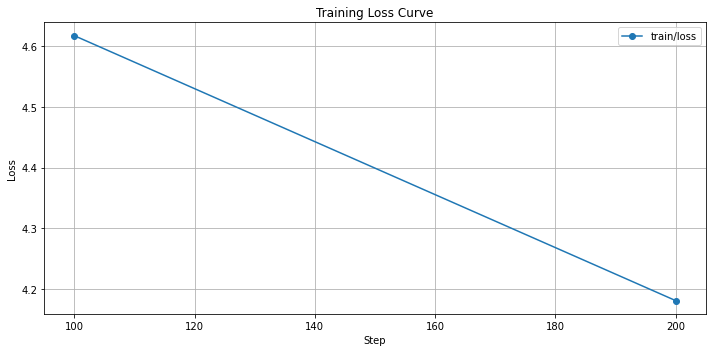

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.trainedtokenizer.10M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available scalar tags:
['train/loss']
train/loss


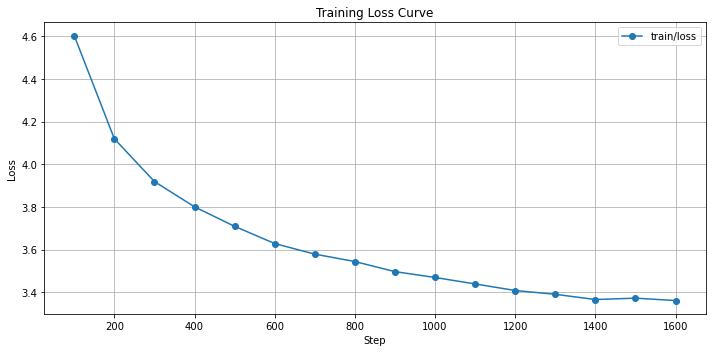

In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.trainedtokenizer.100M')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        print(tag)
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
train/loss


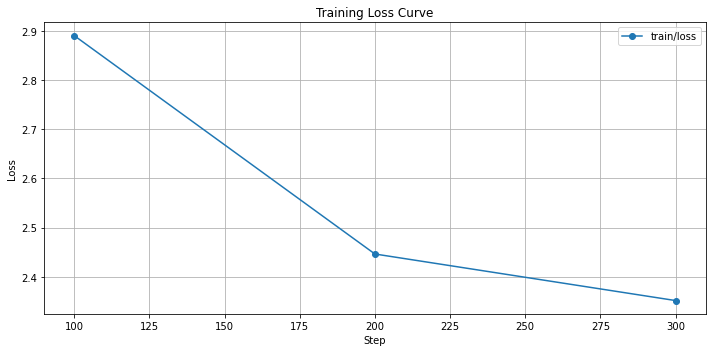

In [11]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.trainedtokenizer.10M.whitespace')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        print(tag)
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available scalar tags:
['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
train/loss


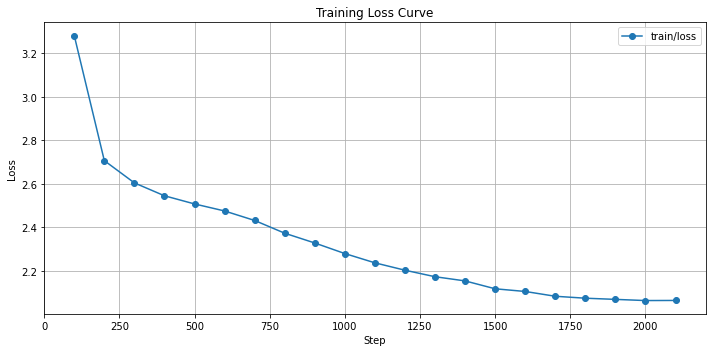

In [12]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = './gpt3-small/logs'

event_path = os.path.join(log_dir, 'events.out.tfevents.trainedtokenizer.100M.whitespace')
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# list all scalar tags
print("Available scalar tags:")
print(event_acc.Tags()["scalars"])

# try common tags
possible_tags = ["loss", "train/loss", "training_loss"]
tag = None
for t in possible_tags:
    if t in event_acc.Tags()["scalars"]:
        tag = t
        print(tag)
        break

assert tag, f"Could not find expected loss tag. Found: {event_acc.Tags()['scalars']}"

# extract data
events = event_acc.Scalars(tag)
steps = [e.step for e in events]
values = [e.value for e in events]

# plotting
plt.figure(figsize = (10, 5))
plt.plot(steps, values, marker = "o", label = tag)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()